# Отток клиентов

## Подготовка данных

In [55]:
import pandas as pd
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, roc_auc_score

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [56]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


В таблице Churn находятся данные о клиентах банка и их взаимодействии с банком. Целевой признак - столбец Exited.

In [57]:
print(data.info())

print(data.duplicated().sum())
print(data['Geography'].unique())
print(data['Gender'].unique())
print(data.min(numeric_only=True))
print(data.max(numeric_only=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None
0
['France' 'Spain' 'Germany']
['Female' 'Male']
RowNumber                 1.00
CustomerI

В столбце Tenure есть пропуски, их можно заполнить нулями. Дубликатов в данных нет. Для предсказания ухода клиента столбцы с их уникальными номерами, фамилиями и номером в списке не нужны - удалю их. Есть два категориальных признака - Geography и Gender.	
В численных признаках нет подозрительно маленьких и больших значений кроме предполагаемой зарплаты:

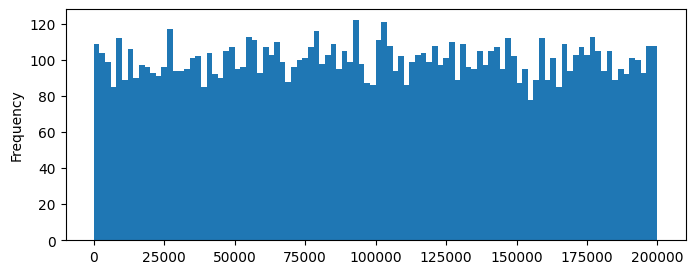

In [58]:
data['EstimatedSalary'].plot(kind='hist', bins=100, figsize=(8,3));

но на графике с ней нет выбивающихся значений.

In [59]:
data['Tenure'] = data['Tenure'].fillna(0)
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB
None


In [60]:
print(data['Exited'].value_counts(normalize=1))

0    0.7963
1    0.2037
Name: Exited, dtype: float64


Соотношение классов в целевом признаке далеко от равного - ушедших клиентов в 4 раза меньше. Необходимо будет провести баланс классов. Но сначала подготовлю данные для обучения: проведу разделение на три выборки, порядковое кодирование и стандартизацию данных.

In [61]:
target = data['Exited']
features = data.drop('Exited', axis=1)

features_train, features_, target_train, target_ = train_test_split(
    features, target, test_size=0.4, random_state=12, stratify=target)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_, target_, test_size=0.5, random_state=12, stratify=target_)

target_train = target_train.reset_index(drop=True)
target_valid = target_valid.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

print('размер тренировочной выборки:', features_train.shape[0])
print('размер валидационной выборки:', features_valid.shape[0])
print('размер тестовой выборки:', features_test.shape[0])

размер тренировочной выборки: 6000
размер валидационной выборки: 2000
размер тестовой выборки: 2000


In [62]:
encoder = OrdinalEncoder()

features_train = pd.DataFrame(encoder.fit_transform(features_train), columns=features_train.columns)
features_valid = pd.DataFrame(encoder.fit_transform(features_valid), columns=features_valid.columns)
features_test = pd.DataFrame(encoder.fit_transform(features_test), columns=features_test.columns)

features_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,232.0,0.0,1.0,7.0,1.0,0.0,0.0,1.0,0.0,2988.0
1,353.0,1.0,1.0,47.0,1.0,2698.0,0.0,1.0,1.0,3644.0
2,273.0,1.0,0.0,9.0,4.0,1476.0,0.0,0.0,1.0,657.0
3,142.0,2.0,0.0,28.0,5.0,2899.0,0.0,1.0,1.0,2507.0
4,294.0,0.0,1.0,10.0,0.0,3651.0,1.0,1.0,1.0,2612.0


In [63]:
numeric = ['CreditScore', 'Age', 'Tenure','Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,-0.187491,0.0,1.0,-1.326716,-1.127634,-0.957047,-0.911792,1.0,0.0,-0.006640
1,1.074630,1.0,1.0,2.450724,-1.127634,1.161348,-0.911792,1.0,1.0,0.372102
2,0.240170,1.0,0.0,-1.137844,-0.167673,0.201868,-0.911792,0.0,1.0,-1.352443
3,-1.126259,2.0,0.0,0.656440,0.152314,1.319168,-0.911792,1.0,1.0,-0.284345
4,0.459216,0.0,1.0,-1.043408,-1.447621,1.909618,0.809653,1.0,1.0,-0.223723


Данные подготовлены: в них нет ненужных столбцов, значения подходят для обучения модели.

## Исследование задачи

Нужно спрогнозировать уход клиента. Качество прогноза будет измерятся f1-мерой, цель - обучить модель, для которой эта метрика будет больше 0.59.

Я буду изучать работу трех моделей: дерева классификации, случайного леса и логистической регрессии. Сначала обучу модели на данных с дисбалансом

### Дерево классификации

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 26.59it/s]


глубина: 7
f1-мера: 0.5217391304347826
auc-roc: 0.8190015641935167


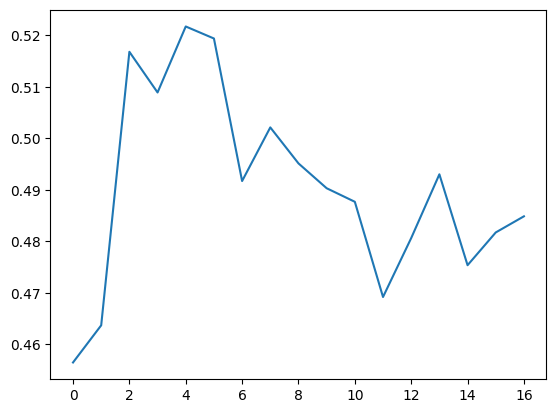

In [64]:
best_depth_tree = 0
best_f1 = 0
best_roc = 0

proc = []
for depth in tqdm(range(3, 20)):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)

    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
    proc.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_depth_tree = depth
        best_roc = auc_roc
        
plt.plot(proc)
print('глубина:', best_depth_tree)
print('f1-мера:', best_f1)
print('auc-roc:', best_roc)

На графике видно, как меняется значение f1-меры - сначала значение растет, но после достижения некоторой глубины дерево переобучается, и качество предсказаний падает.

### Случайный лес

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.22s/it]


деревья: 21
глубина: 14
f1-мера: 0.548780487804878
auc-roc: 0.8233469738397872


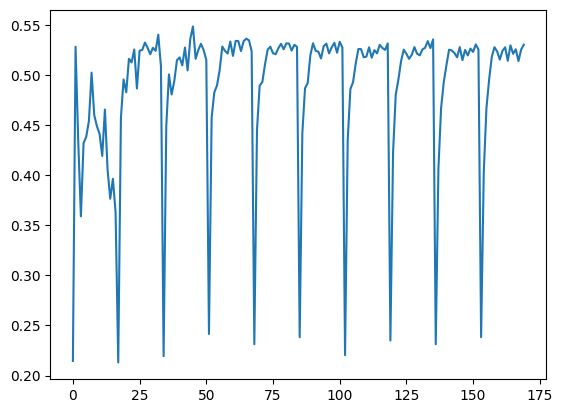

In [65]:
best_trees = 0
best_depth = 0
best_f1 = 0
best_roc = 0

proc = []

for trees in tqdm(range(1, 101, 10)):
    for depth in range(3, 20):
        model = RandomForestClassifier(n_estimators=trees, max_depth=depth, random_state=12)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)

        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]

        f1 = f1_score(target_valid, predicted_valid)
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

        proc.append(f1)
        
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_trees = trees
            best_roc = auc_roc

plt.plot(proc)
print('деревья:', best_trees)        
print('глубина:', best_depth)
print('f1-мера:', best_f1)
print('auc-roc:', best_roc)

У леса результат лучше - 0.54. Также немного лучше стало значение AUC-ROC.

На графике видно, как циклично менялась f1-мера в процессе обучения - на малой глубине дерева значения такие же малые. После достижения 30 деревьев улучшения метрики нет.

### Логистическая регрессия

In [66]:
%%time
model = LogisticRegression(solver='liblinear', random_state=12)

model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_1 = f1_score(target_valid, predicted_valid)
auc_roc_1 = roc_auc_score(target_valid, probabilities_one_valid)
print('f1-мера:', f1_1)
print('auc-roc:', auc_roc_1)

f1-мера: 0.21951219512195122
auc-roc: 0.7329139570401025
CPU times: total: 31.2 ms
Wall time: 34 ms


Похоже, что логистическая регрессия не "видит" взаимосвязей в этих данных так, как "видят" деревья.

## Борьба с дисбалансом

In [67]:
target_valid.value_counts(normalize=1)

0    0.796
1    0.204
Name: Exited, dtype: float64

Положительный класс меньше отрицательного в 4 раза. Можно сбалансировать их разными способами, например провести upsampling, dowsampling или передать самой модели параметр, отвечающий за равный вес классов.     
Напишу функцию, которая проведет баланс классов, обучит модель и посчитает F1-меру и AUC-ROC. На вход функция получает саму модель, гиперпараметры для нее, тренировочную и валидационную выборки, возвращает значения метрик:

In [68]:
def score_model(model, params, features_train, target_train, features_valid, target_valid):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]

    if params['class_weight'] == 'upsample':
        repeat = float(round(target_train.value_counts(normalize=1)[0] / target_train.value_counts(normalize=1)[1]))
        features_upsampled = pd.concat([features_zeros, features_ones.sample(frac=repeat, replace = True, random_state=12)])
        target_upsampled = pd.concat([target_zeros, target_ones.sample(frac=repeat, replace = True, random_state=12)])
        
        features_train, target_train = shuffle(features_train, target_train, random_state=12)
        params['class_weight'] = None
   
    if params['class_weight'] == 'downsample':
        fraction = float(round(target_train.value_counts(normalize=1)[1] / target_train.value_counts(normalize=1)[0], 2))
        features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12), features_ones])
        target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12), target_ones])
        
        features_train, target_train = shuffle(features_train, target_train, random_state=12)
        params['class_weight'] = None

    model_obj = model(**params).fit(features_train, target_train)
    probabilities_valid = model_obj.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    f1 = f1_score(target_valid, model_obj.predict(features_valid))
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
    return f1, auc_roc

Теперь можно начать подбор гиперпараметров.

### Дерево решений

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.27it/s]


{'max_depth': 6, 'class_weight': 'balanced', 'random_state': 12, 'f1': 0.5644670050761421, 'auc_roc': 0.8156306963740271}


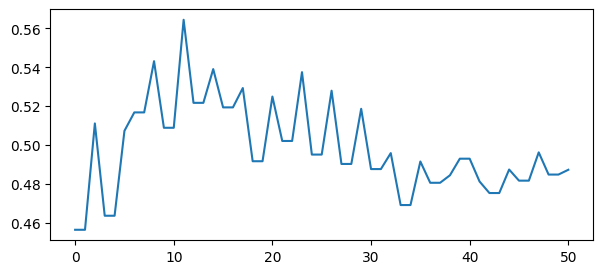

In [69]:
params_tree = {'max_depth': list(range(3, 20)),
               'random_state': [12],
               'class_weight': ['upsample', 'downsample', 'balanced']}

score_tracker = []
for max_depth in tqdm(params_tree['max_depth']):
    for class_weight in params_tree['class_weight']:
        params_ = {'max_depth': max_depth,
                   'class_weight': class_weight,
                   'random_state': 12}
        params_['f1'], params_['auc_roc'] = score_model(DecisionTreeClassifier, params_,
                                              features_train, target_train, features_valid, target_valid)
        params_['class_weight'] = class_weight
        score_tracker.append(params_)
        
plt.figure(figsize=(7, 3))        
plt.plot([scores['f1'] for scores in score_tracker])
tree_best = sorted(score_tracker, key=lambda x: x['f1'], reverse=True)[0]
print(tree_best)

Лучшие гиперпараметры для дерева решений - глубина 6 с балансом классов - дают F1-меру равную 0.564.

### Случайный лес

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:43<00:00, 28.36s/it]

{'n_estimators': 31, 'max_depth': 9, 'random_state': 12, 'class_weight': 'balanced', 'f1': 0.586248492159228, 'auc_roc': 0.8428955438959503}


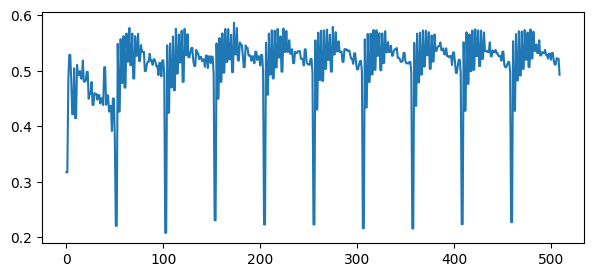

In [70]:
params_forest = {'n_estimators': list(range(1, 101, 10)),
                 'max_depth': list(range(3, 20)), 
                 'random_state': [12],
                 'class_weight': ['upsample', 'downsample', 'balanced']}
score_tracker = []
for trees in tqdm(params_forest['n_estimators']):
    for depth in params_forest['max_depth']:
        for class_weight in params_forest['class_weight']:
            params_ = {'n_estimators': trees,
                       'max_depth': depth,
                       'random_state': 12,
                       'class_weight': class_weight}
            params_['f1'], params_['auc_roc'] = score_model(RandomForestClassifier, params_,
                                                  features_train, target_train, features_valid, target_valid)
            params_['class_weight'] = class_weight
            score_tracker.append(params_)

plt.figure(figsize=(7, 3))
plt.plot([scores['f1'] for scores in score_tracker])
forest_best = sorted(score_tracker, key=lambda x: x['f1'], reverse=True)[0]
print(forest_best)

Лучший результат у леса больше, чем у дерева - F1-мера равна 0.586. Гиперпараметры - 31 дерево, глубина 9, `class_weight` -`balanced`.

### Логистическая регрессия

In [75]:
params_logreg = {'solver': ['liblinear'],
                 'random_state': [12],
                 'class_weight': ['upsample', 'downsample', 'balanced']}

score_tracker = []
for class_weight in tqdm(params_logreg['class_weight']):
        params_ = {'class_weight': class_weight,
                   'random_state': 1}
        params_['f1'], params_['auc_roc'] = score_model(LogisticRegression, params_,
                                                  features_train, target_train, features_valid, target_valid)
        params_['class_weight'] = class_weight
        score_tracker.append(params_)

log_best = sorted(score_tracker, key=lambda x: x['f1'], reverse=True)[0]
print(log_best)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 29.68it/s]

{'class_weight': 'balanced', 'random_state': 1, 'f1': 0.4591439688715953, 'auc_roc': 0.7366381540053207}


При сбалансированных классах F1-мера логистической регрессии улучшилась в два раза! Лучший результат равен 0.46, что все еще меньше, чем у других моделей.

После проверки всех комбинаций гиперпараметров модели и способов балансировки, можно сказать, что случайный лес в целом лучше справляется с предсказаниями - у него самые высокие значения метрик. Самая лучшая f1-мера - 0.586 - получена после баланса классов, на модели с 31 деревом и их глубиной 9.

## Тестирование модели

{'n_estimators': 31, 'max_depth': 9, 'random_state': 12, 'class_weight': 'balanced'}
f1-мера: 0.6120906801007557
auc-roc: 0.8445417682705817


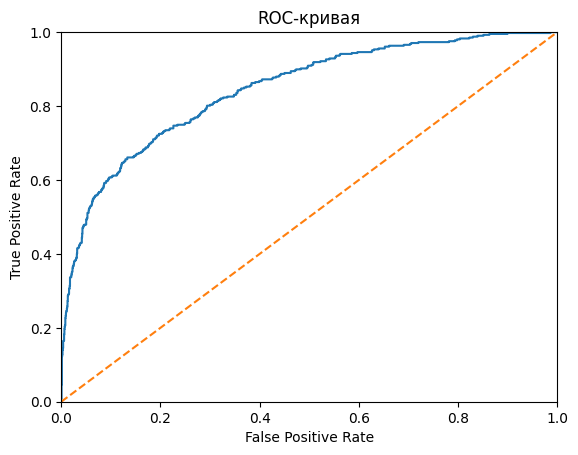

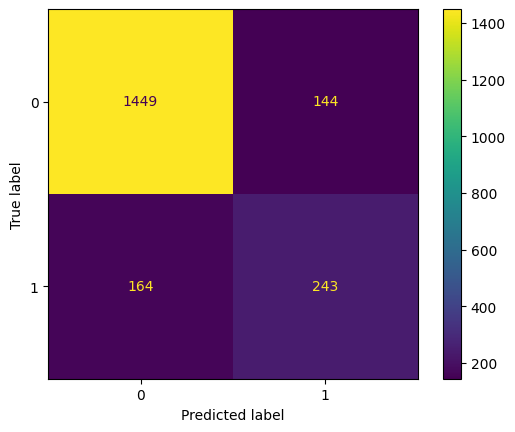

In [92]:
forest_best.pop('f1', forest_best)
forest_best.pop('auc_roc', forest_best)
print(forest_best)
fin_model = RandomForestClassifier(**forest_best)
fin_model.fit(features_train, target_train)

predicted_test = fin_model.predict(features_test)
probabilities_test = fin_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

f1 = f1_score(target_test, predicted_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('f1-мера:', f1)
print('auc-roc:', auc_roc)

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

# ROC-кривая тестируемой модели
plt.plot(fpr, tpr)
# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

# матрица ошибок
cm = confusion_matrix(target_test, predicted_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot();

Тестируемая модель дает значение f1-меры 0.612 - цель исследования достигнута. На протяжении всей работы значение AUC-ROC не превышало 0.85 ни для одной модели, у тестируемой оно равно 0.844. ROC-кривая модели на графике выше, чем ROC-кривая случайной модели. Из матрицы ошибок видно, что лучше всего модель предсказывает класс 0.

Итог: лучшая модель - случайный лес с балансом классов; лучшие найденные параметры - 31 дерево, глубина 9.

Была проделана следующая работа:
- подготовлены данные: отсеяны ненужные признаки, нужные признаки приведены к формату, пригодному для обучения модели;
- исследованы три типа моделей;
- исследован дисбаланс классов, проведен upsampling данных;
- upsampling тренировочной + валидационной выборки, обучение модели на увеличенной выборке;
- тестирование модели